# Flowmap generator

In [4]:
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
Image.MAX_IMAGE_PIXELS = None

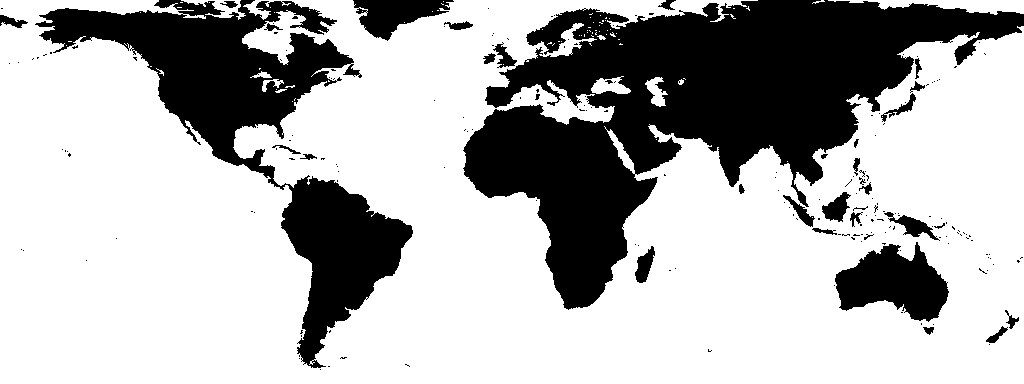

In [5]:
# Load black-LAND (RGB 0,0,0) and white-SEA (RGB 255 255 255) image in grayscale mode
im = Image.open(r"input files/heightmap.png","r").convert('L')#.crop((0,0,400,200))
display(im)

In [40]:
def findNearest(targets, x0, y0):
    distances = np.sqrt((targets[:,0] - y0) ** 2 + (targets[:,1] - x0) ** 2)
    nearest = np.argsort(distances)[:]
    weights = np.divide(1, distances[nearest]**3)
    y, x = int(np.average(targets[nearest,0], weights=weights)), int(np.average(targets[nearest,1], weights=weights))
    return np.sqrt((x-x0)**2+(y-y0)**2), y, x
    #return distances[nearest[0]], y, x
    

def colorGradient(component, radius, maxRadius, gradientType, lowerRadius=2):
    if gradientType=='lineal':
        temp = min((maxRadius-radius)/maxRadius, 0.4)
    elif gradientType=='exponential':
        temp = -np.log(1/100)/(maxRadius-1)
        temp = np.exp(-temp*(radius-1))

    elif gradientType=='both':
        if radius<=lowerRadius:
            temp = (maxRadius-1)/maxRadius
        else:
            temp = -np.log(1/150)/(maxRadius-1)
            temp = (maxRadius-1)/maxRadius*np.exp(-temp*(radius-lowerRadius))
    else: raise ValueError('Wrong gradient type introduced')

    return int(round(component*127*temp+128))

def inner_loop(x0, imData, imData2, white, seaRadius, landRadius, lowerRadius):
    temp = []

    for y0 in range(im.height):
        
        #SEA
        if im.getpixel((x0,y0))==white:
            xlim = [max(0, x0-seaRadius), min(im.width-1, x0+seaRadius)]
            ximData = imData[(imData[:,1]>=xlim[0]) & (imData[:,1]<=xlim[1])]
            ximData2 = imData2[(imData2[:,1]>=xlim[0]) & (imData2[:,1]<=xlim[1])]
            ylim = [max(0, y0-seaRadius), min(im.height-1, y0+seaRadius)]
            xyimData = ximData[(ximData[:,0]>=ylim[0]) & (ximData[:,0]<=ylim[1])]
            if len(xyimData)==0: 
                temp.append([x0,y0,128,128,255])
                continue
            radius, y, x = findNearest(xyimData, x0, y0)
            if radius>seaRadius or radius==0:
                temp.append([x0,y0,128,128,255])
                continue

            xdist, ydist = (x-x0)/radius, (y0-y)/radius
            red = colorGradient(xdist, radius, seaRadius, gradientType='both', lowerRadius=lowerRadius)
            green = colorGradient(ydist, radius, seaRadius, gradientType='both', lowerRadius=lowerRadius)
            blue = int(round(128+127*radius/seaRadius))
            temp.append([x0,y0,red,green,blue])

        #LAND
        else:
            xlim = [max(0, x0-landRadius), min(im.width-1, x0+landRadius)]
            ximData = imData[(imData[:,1]>=xlim[0]) & (imData[:,1]<=xlim[1])]
            ximData2 = imData2[(imData2[:,1]>=xlim[0]) & (imData2[:,1]<=xlim[1])]
            ylim = [max(0, y0-landRadius), min(im.height-1, y0+landRadius)]
            xyimData2 = ximData2[(ximData2[:,0]>=ylim[0]) & (ximData2[:,0]<=ylim[1])]
            if len(xyimData2)==0: 
                temp.append([x0,y0,128,128,255])
                continue
            radius, y, x = findNearest(xyimData2, x0, y0)
            if radius>landRadius or radius==0:
                temp.append([x0,y0,128,128,255])
                continue

            xdist, ydist = (x-x0)/radius, (y0-y)/radius
            red = colorGradient(xdist, radius, landRadius, gradientType='lineal')
            green = colorGradient(ydist, radius, landRadius, gradientType='lineal')
            blue = int(round(128+127*radius/landRadius))
            temp.append([x0,y0,red,green,blue])
    return temp

In [42]:
#### USER PARAMETERS
# Controls the size of all the colored land/sea area near the coast, in pixels
seaRadius = 4
landRadius = 20

# Controls the size of the strip of "strongly" colored area in the sea near the coast, in pixels
lowerRadius = 3
#### USER PARAMETERS
# If your heightmap is like ck3 in terms of pixel density, good values are 40 and 2-4
# If your heightmap has 4 times less pixel density like in A Broken World, good values are 20 and 1-2

  0%|          | 0/1024 [00:00<?, ?it/s]

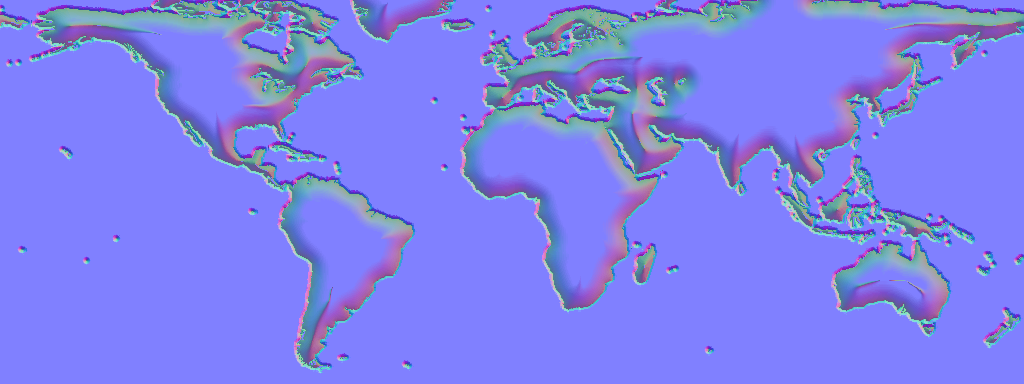

In [43]:
gradientType = 'both'
black, white, blue = 0, 255, 255
flowmap = Image.new('RGB',im.size)

imData = np.argwhere(np.array(im) == black)
imData2 = np.argwhere(np.array(im) == white)

result = Parallel(n_jobs=-2)(delayed(inner_loop)(x0, imData, imData2, white, seaRadius, landRadius, lowerRadius) for x0 in tqdm(range(im.width)))

for x0 in result:
    for elem in x0:
        flowmap.putpixel((elem[0], elem[1]), (elem[2], elem[3], elem[4]))

flowmap.save('output files/flowmap.png')
display(flowmap)